# Feature interactions
The goal of this Notebook is to find the relations between features in selected dataset.

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno


pd.plotting.register_matplotlib_converters()
%matplotlib inline



%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats, help_model

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Selected features
Selected features dataset has 307511 observations and 21 features. No duplicates.

Selected features are mainly from current application. Aggregated features used from Previous applications (after feature selection): 
* AVG_Risk_Score (MEAN(df.NAME_YIELD_GROUP)) - risk ranking average, where the higher the number, the higher the risk
* MAX(df.DURATION_DUE_VERSION), MAX(df.DURATION_DECISION_DRAWING), MIN(df.RATIO_GOODS_PRICE_CREDIT), MIN(df.DURATION_DECISION_DRAWING) - expected payment delivery delays, disbursement time, ratio between Credit and Loan amount, duration between decision and drawing.

In [53]:
selected_data = help_tool.csv_download(
    r'Archive\home-credit-default-risk\selected_data.csv').drop(columns='Unnamed: 0')
help_tool.first_look(selected_data)

Dataset has 307511 observations and 15 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
EXT_SOURCE_1,float64,173378,56.4
NAME_EDUCATION_TYPE,int64,0,0.0
AMT_CREDIT,float64,0,0.0
MAX(df.DURATION_DUE_VERSION),float64,17751,5.8
YEARS_EMPLOYED,float64,0,0.0
EXT_SOURCE_3,float64,60965,19.8
YEARS_BIRTH,float64,0,0.0
MAX(df.DURATION_DECISION_DRAWING),float64,17751,5.8
EXT_SOURCE_2,float64,660,0.2
MIN(df.RATIO_GOODS_PRICE_CREDIT),float64,17438,5.7


## Null values
Features expected to have null values:
* AVG_Risk_Score and DURATION family - from previous applications, missing values show that customer had no previous applications.
* EXT_SOURCE_3, EXT_SOURCE_2, EXT_SOURCE_1 are delivered through external vendours. Vendours may not have information on certain customers.

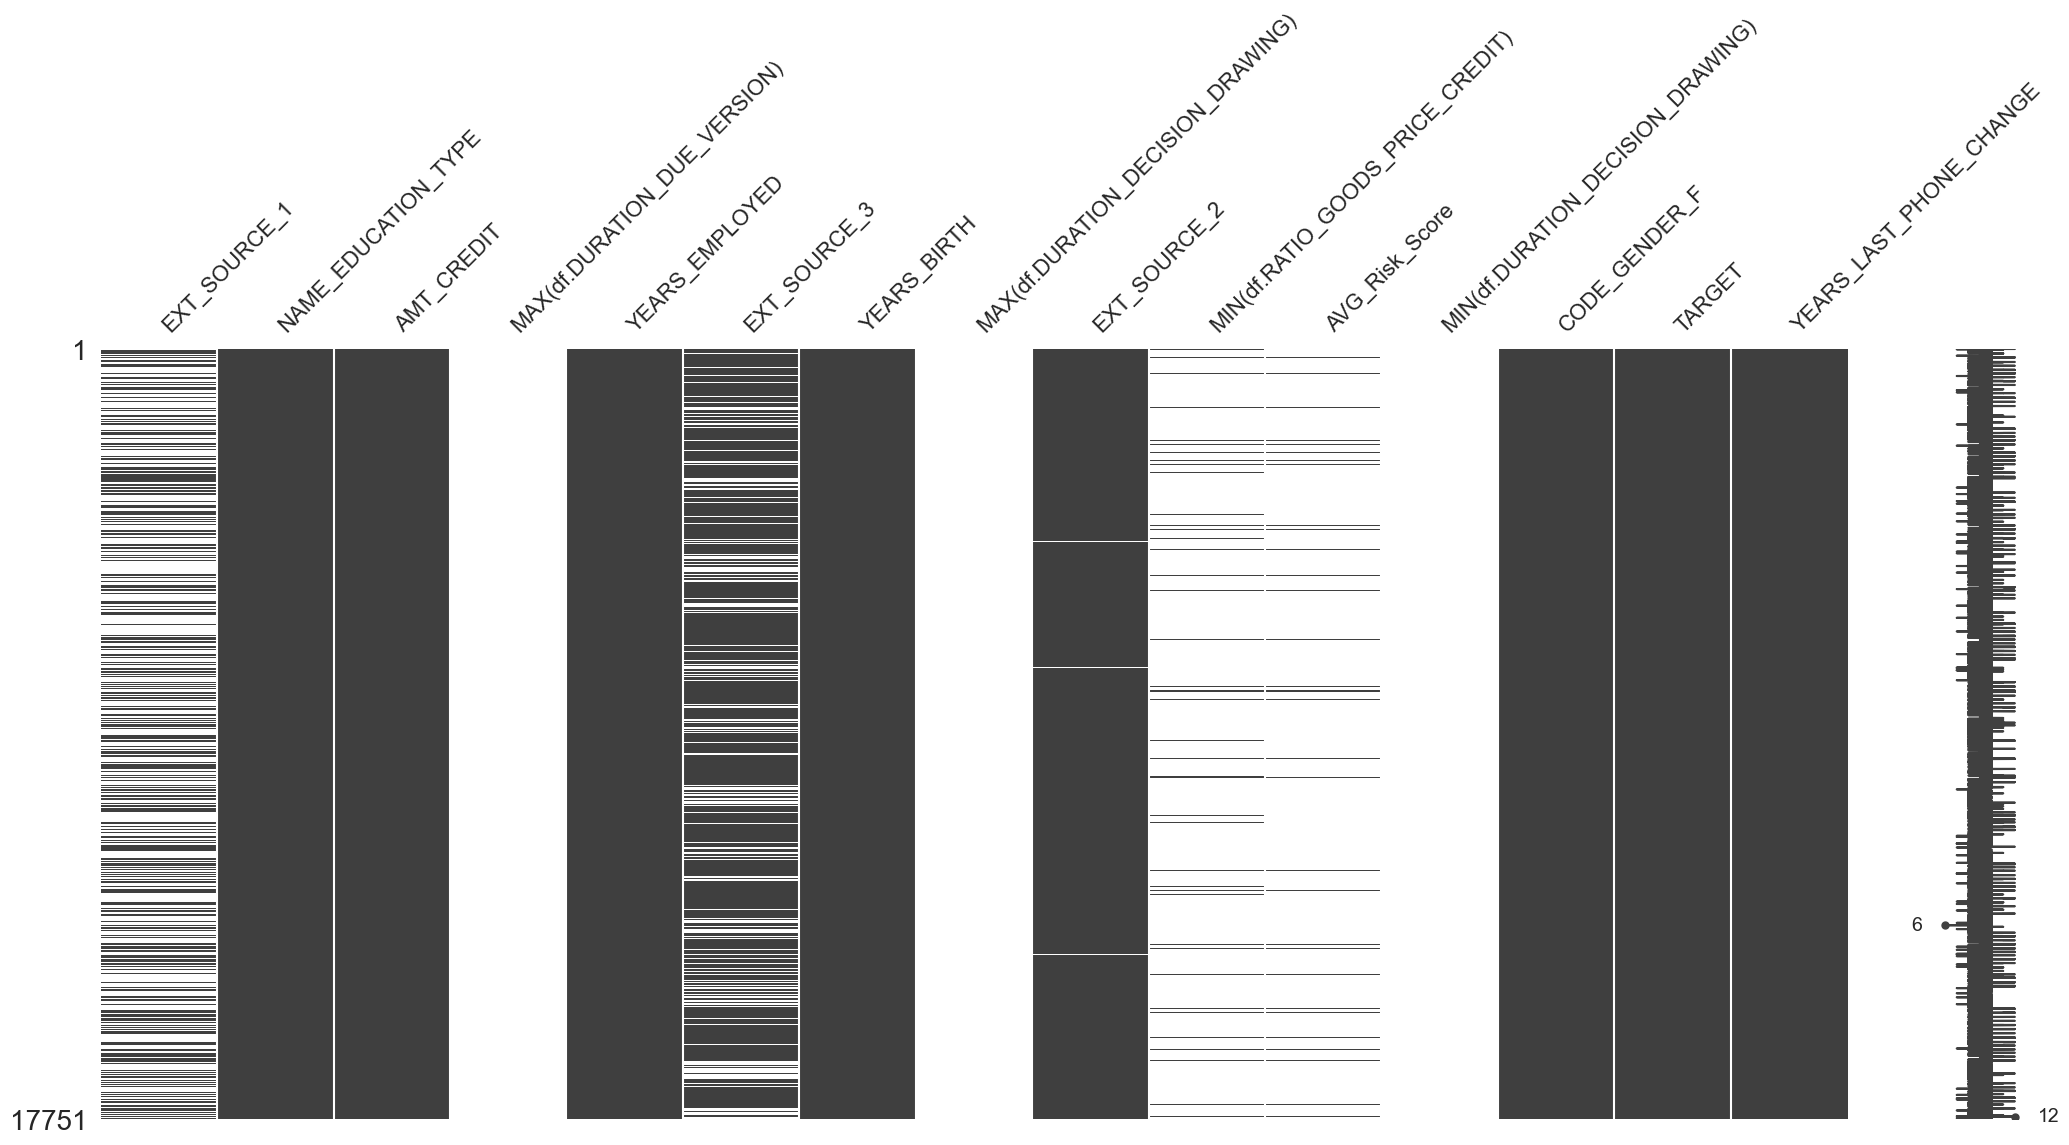

In [54]:
msno.matrix(
    selected_data[selected_data['MIN(df.DURATION_DECISION_DRAWING)'].isna()])
plt.show()

Missing values for Duration family won't be imputed as the missing data is related to missing previous applications.

CODE_GENDER_F is safe to drop null values as they represent the mayority in TARGET.

In [55]:
selected_data[selected_data['CODE_GENDER_F'].isna()]['TARGET'].value_counts()

TARGET
0    4
Name: count, dtype: int64

In [56]:
selected_data = selected_data[selected_data['CODE_GENDER_F'].notna()]

This is not the case with YEARS_LAST_PHONE_CHANGE as it represents the minority class and this row can't be dropped.

In [57]:
selected_data[selected_data['YEARS_LAST_PHONE_CHANGE'].isna()]['TARGET'].value_counts()

TARGET
0    1
Name: count, dtype: int64

# EDA
## Feature distribution

EXT_SOURCE_1


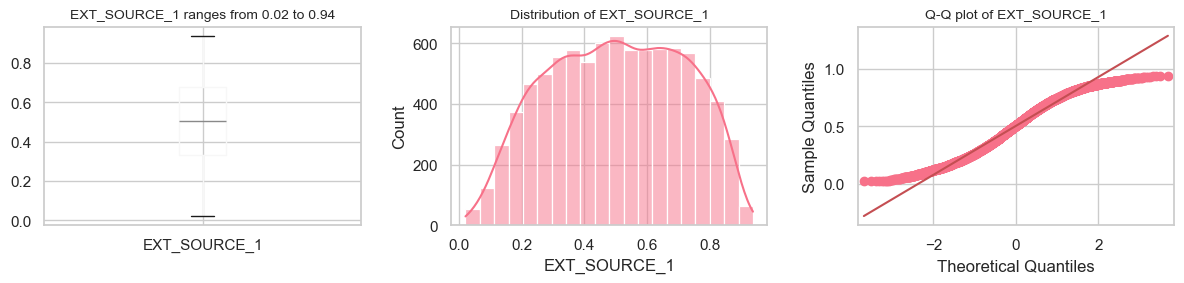

NAME_EDUCATION_TYPE


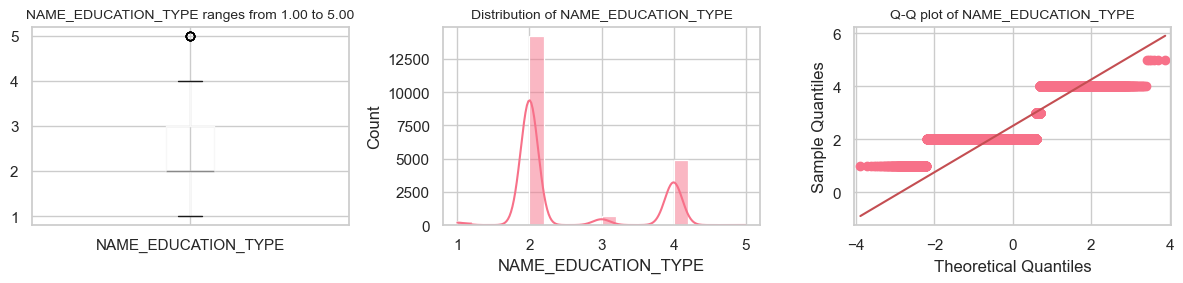

AMT_CREDIT


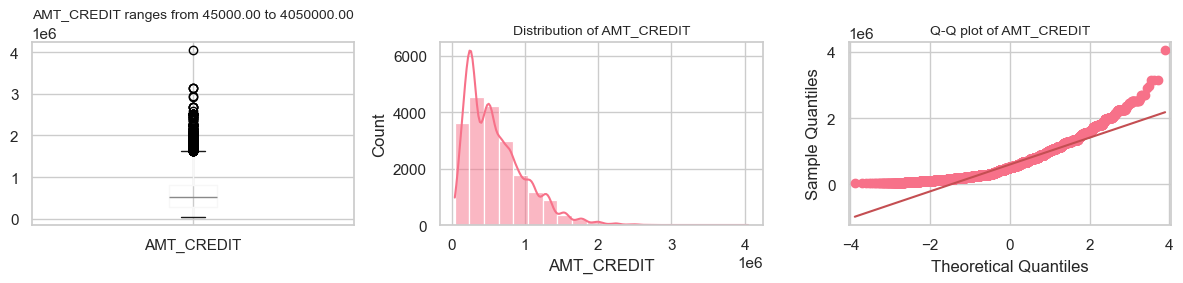

MAX(df.DURATION_DUE_VERSION)


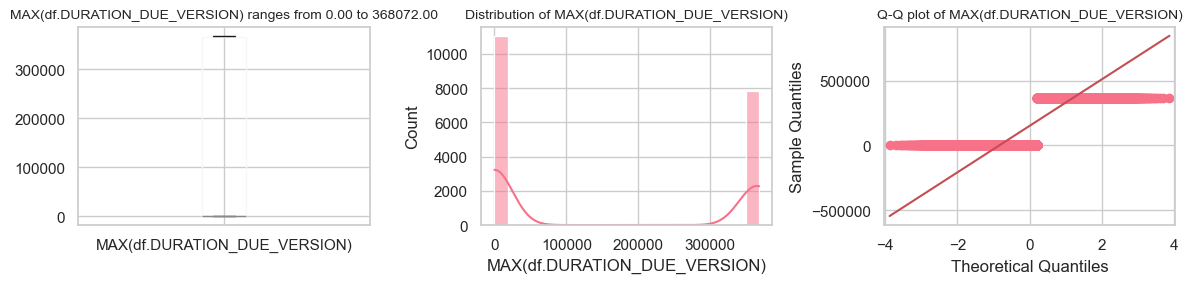

YEARS_EMPLOYED


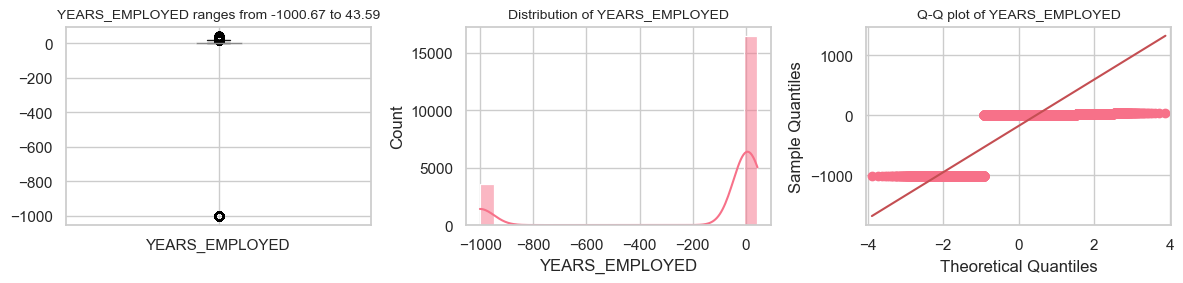

EXT_SOURCE_3


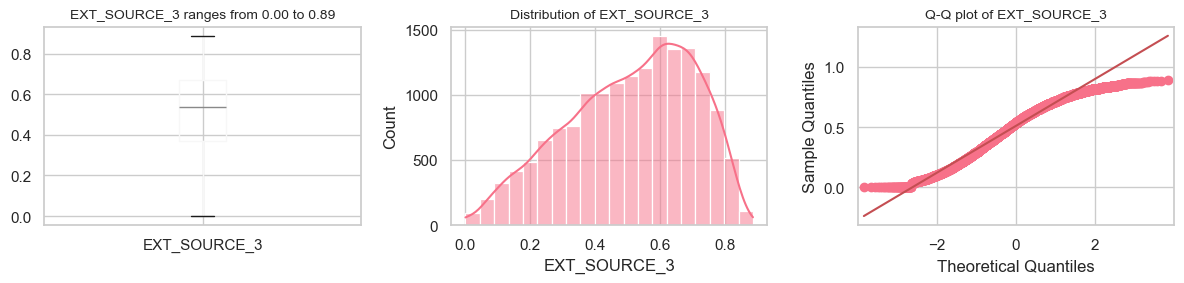

YEARS_BIRTH


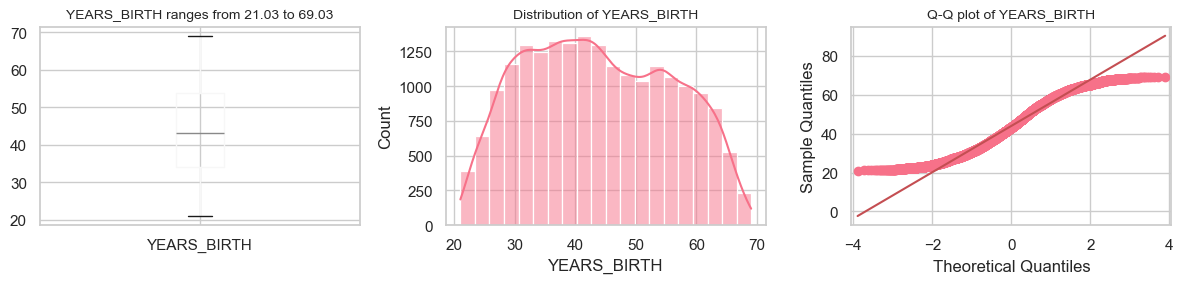

MAX(df.DURATION_DECISION_DRAWING)


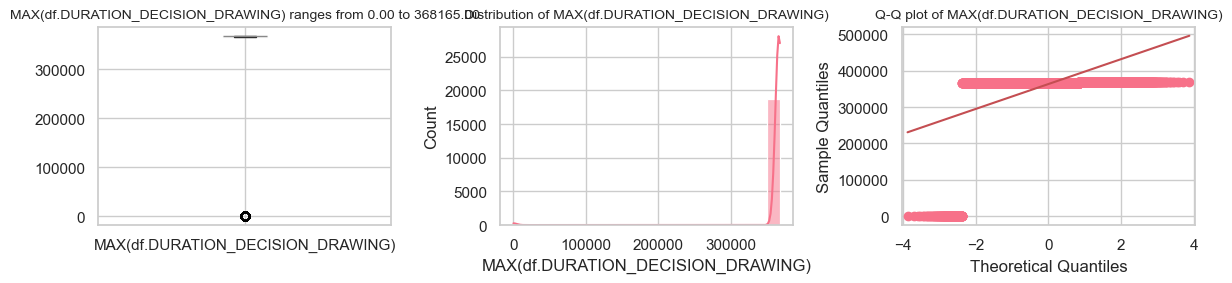

EXT_SOURCE_2


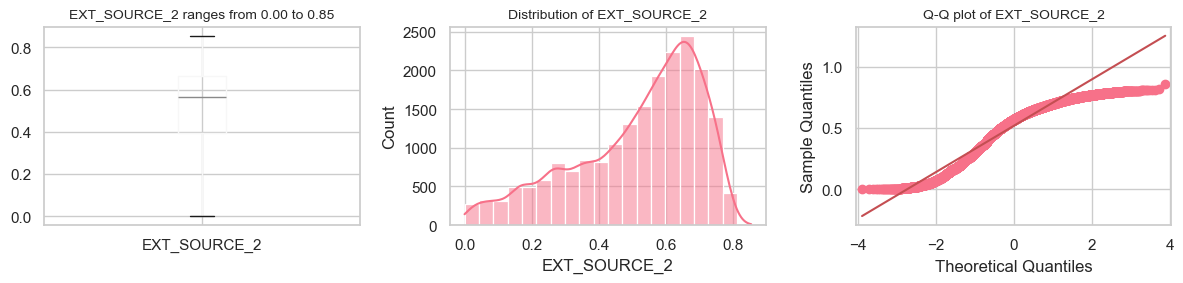

MIN(df.RATIO_GOODS_PRICE_CREDIT)


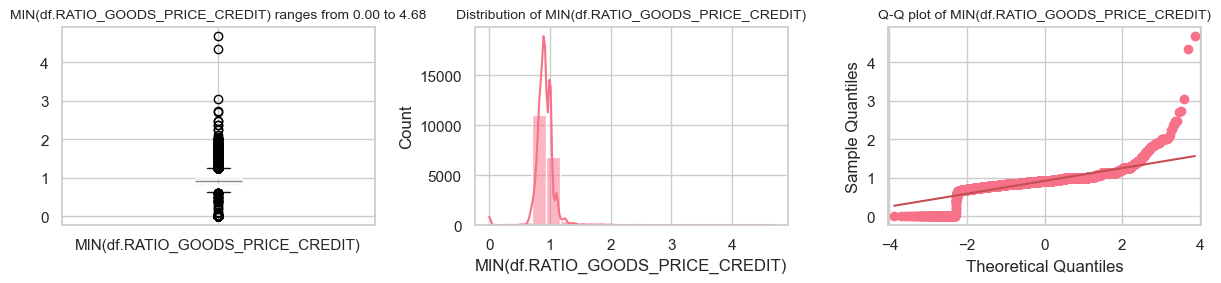

AVG_Risk_Score


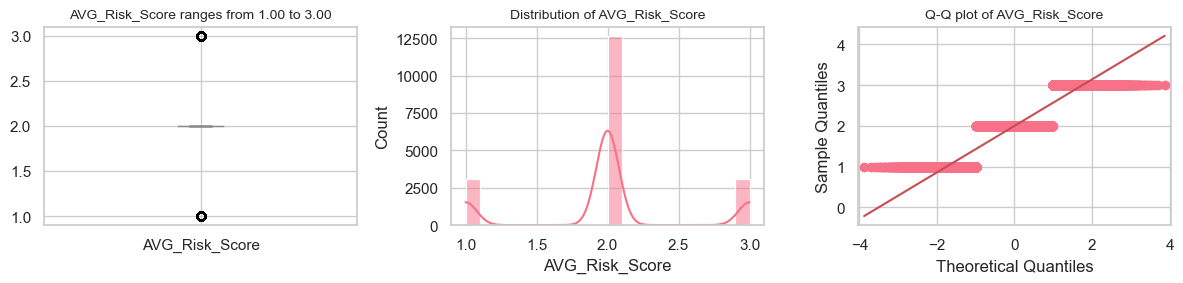

MIN(df.DURATION_DECISION_DRAWING)


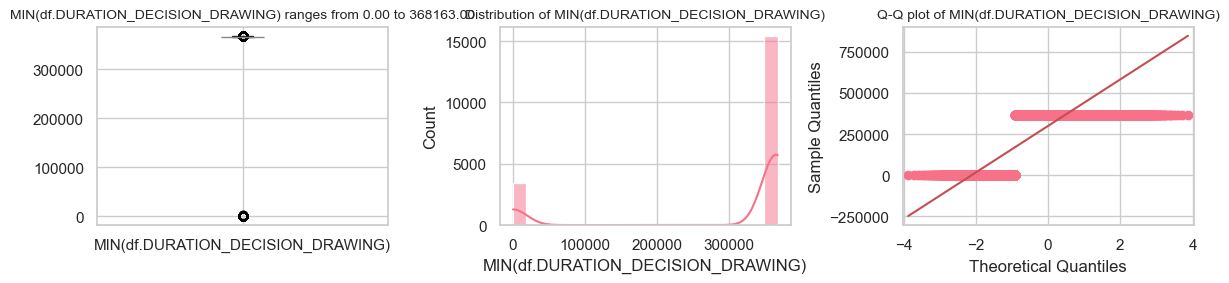

CODE_GENDER_F


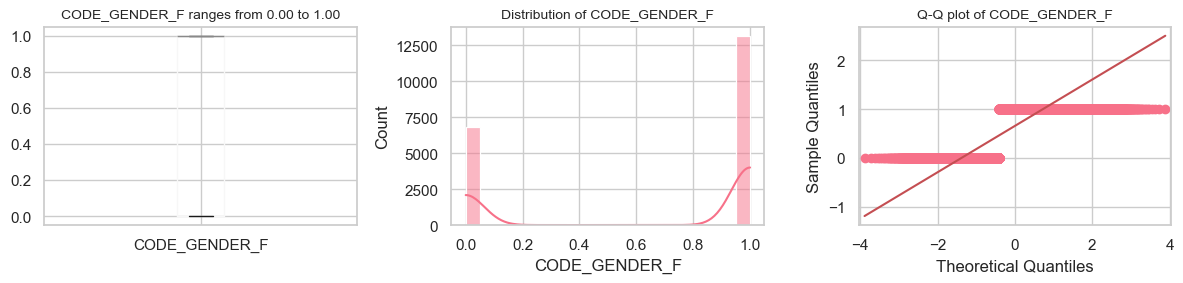

TARGET


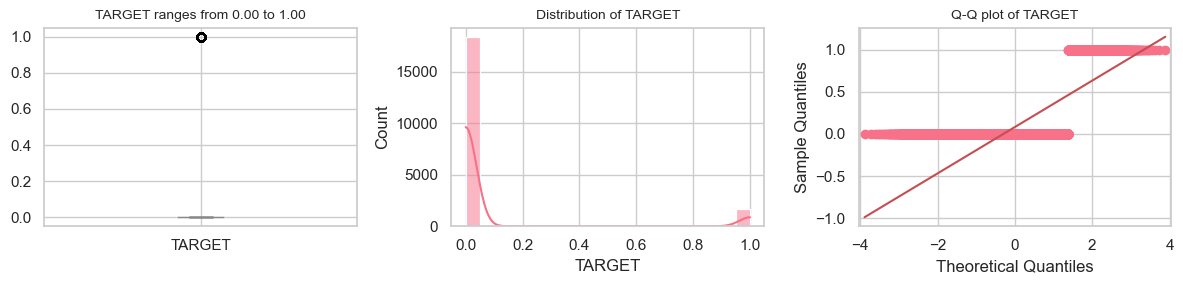

YEARS_LAST_PHONE_CHANGE


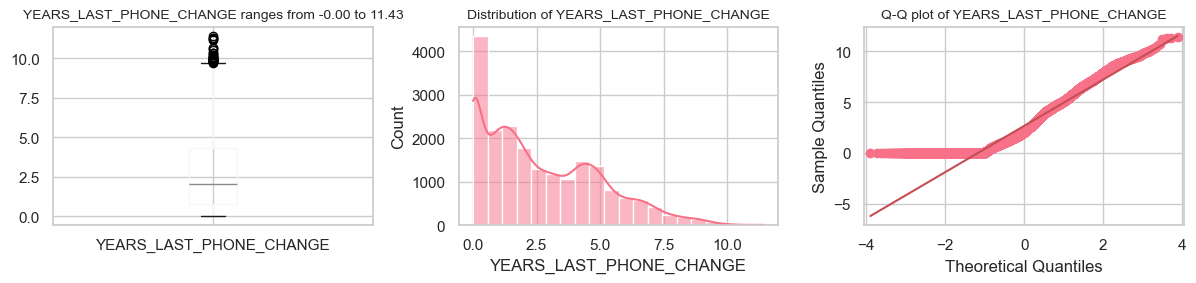

In [58]:
help_visuals.distribution_check(selected_data.sample(20000, random_state=42))

Most features  are skewed, non normally distributed.

DAYS_EMPLOYED seems to have an error - it shows people being employed for 1000 years after their application. But dropping these rows is not an option, as they make up ~12% of 'TARGET'=1. Instead, these values will be set to NaN.

In [59]:
selected_data[selected_data['YEARS_EMPLOYED'] == selected_data['YEARS_EMPLOYED'].min(
)]['TARGET'].value_counts() / selected_data['TARGET'].value_counts() * 100

TARGET
0    18.53107
1    12.04431
Name: count, dtype: float64

Customers with 1000 years of employement have 55374 rows.

In [60]:
selected_data[selected_data['YEARS_EMPLOYED'] ==
              selected_data['YEARS_EMPLOYED'].min()].shape

(55374, 15)

In [61]:
selected_data.loc[selected_data['YEARS_EMPLOYED'] ==
                  selected_data['YEARS_EMPLOYED'].min(), 'YEARS_EMPLOYED'] = np.nan

Let's check how the YEARS_EMPLOYED looks now

YEARS_EMPLOYED


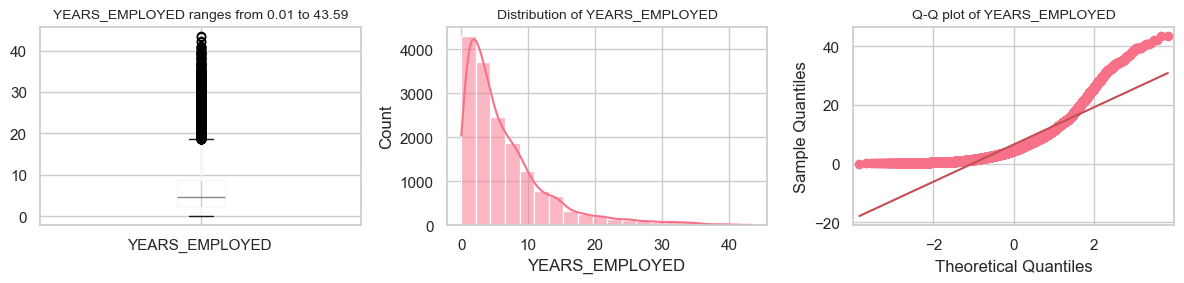

In [62]:
help_visuals.distribution_check(
    selected_data[['YEARS_EMPLOYED']].sample(20000, random_state=42))

Assigning Age to buckets.

In [63]:
def bucket_age_feature(df, age_feature):
    bins = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99, float('inf')]
    labels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    df[f'{age_feature}_bucket'] = pd.cut(
        df[age_feature], bins=bins, labels=labels, right=True, include_lowest=True)

    return df[f'{age_feature}_bucket'].astype(float)


selected_data['YEARS_BIRTH'] = bucket_age_feature(selected_data, 'YEARS_BIRTH')

### Conclusion
Dataset represents:
* Most customers are 'Secondary / secondary special' educated (encoded with 2)
* Have employment of 0-20 years
* Are in their 40s
* Take the exact amount of credit they need for their goods (AMT_GOODS_PRICE / AMT_CREDIT is RATIO_GOODS_PRICE_CREDIT)
* Have medium risk on their previous application (AVG_Risk_Score)
* Are mostly female

## Correlation
Correlation is separated into feature groups of binary, continues and mixed.

In [65]:
binary_features = ['TARGET', 'CODE_GENDER_F']

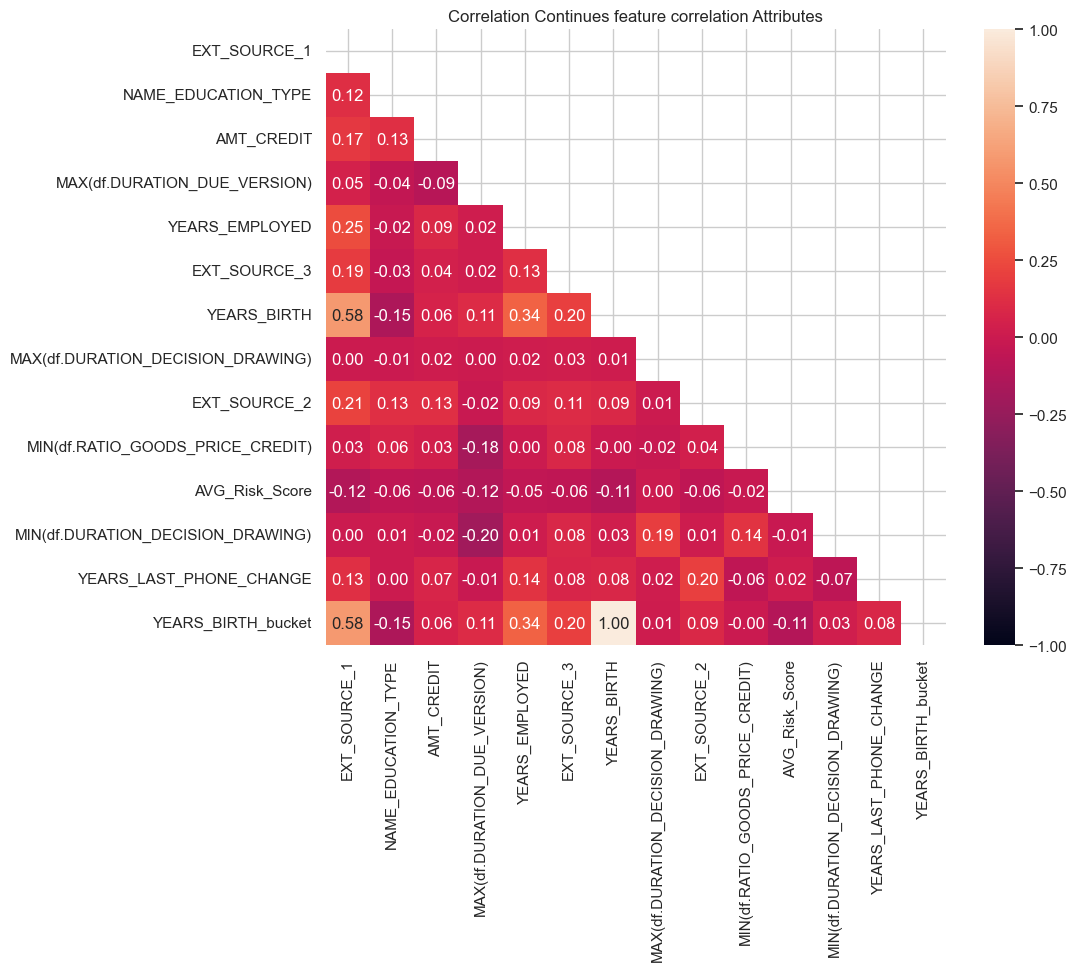

In [66]:
help_visuals.heatmap(selected_data.drop(columns=binary_features),
                     'Continues Feature correlation', 'pearson')
plt.show()

Continues feature correlation shows no strong correlation among selected features. Interestingly, EXT_SOURCE family is not correlated to each other, or to AVG_Risk_Score. This suggests that External sources are derived from other datasets.

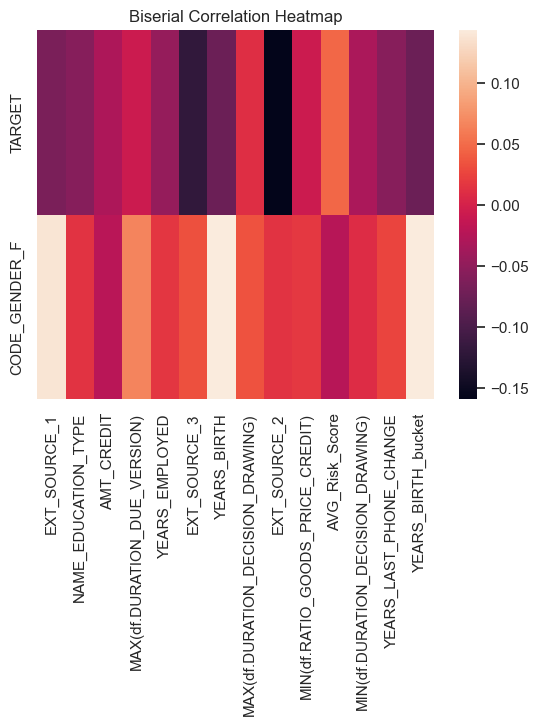

In [67]:
help_stats.biserial_heatmap(selected_data.fillna(0), selected_data.drop(
    columns=binary_features).columns, binary_features)

No biserial correlation between binary and continues features.

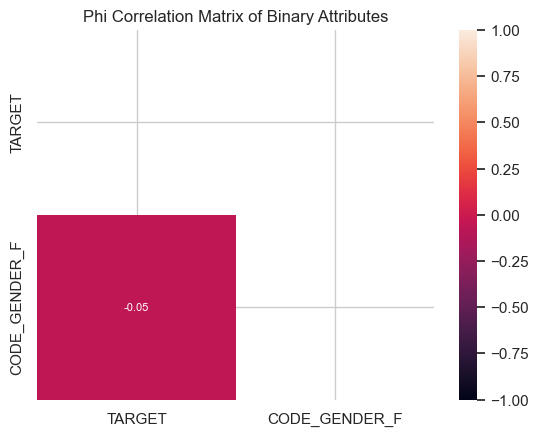

In [68]:
help_stats.phi_corr_matrix(selected_data[binary_features], binary_features)

Also, binary features are not correalted to each other.

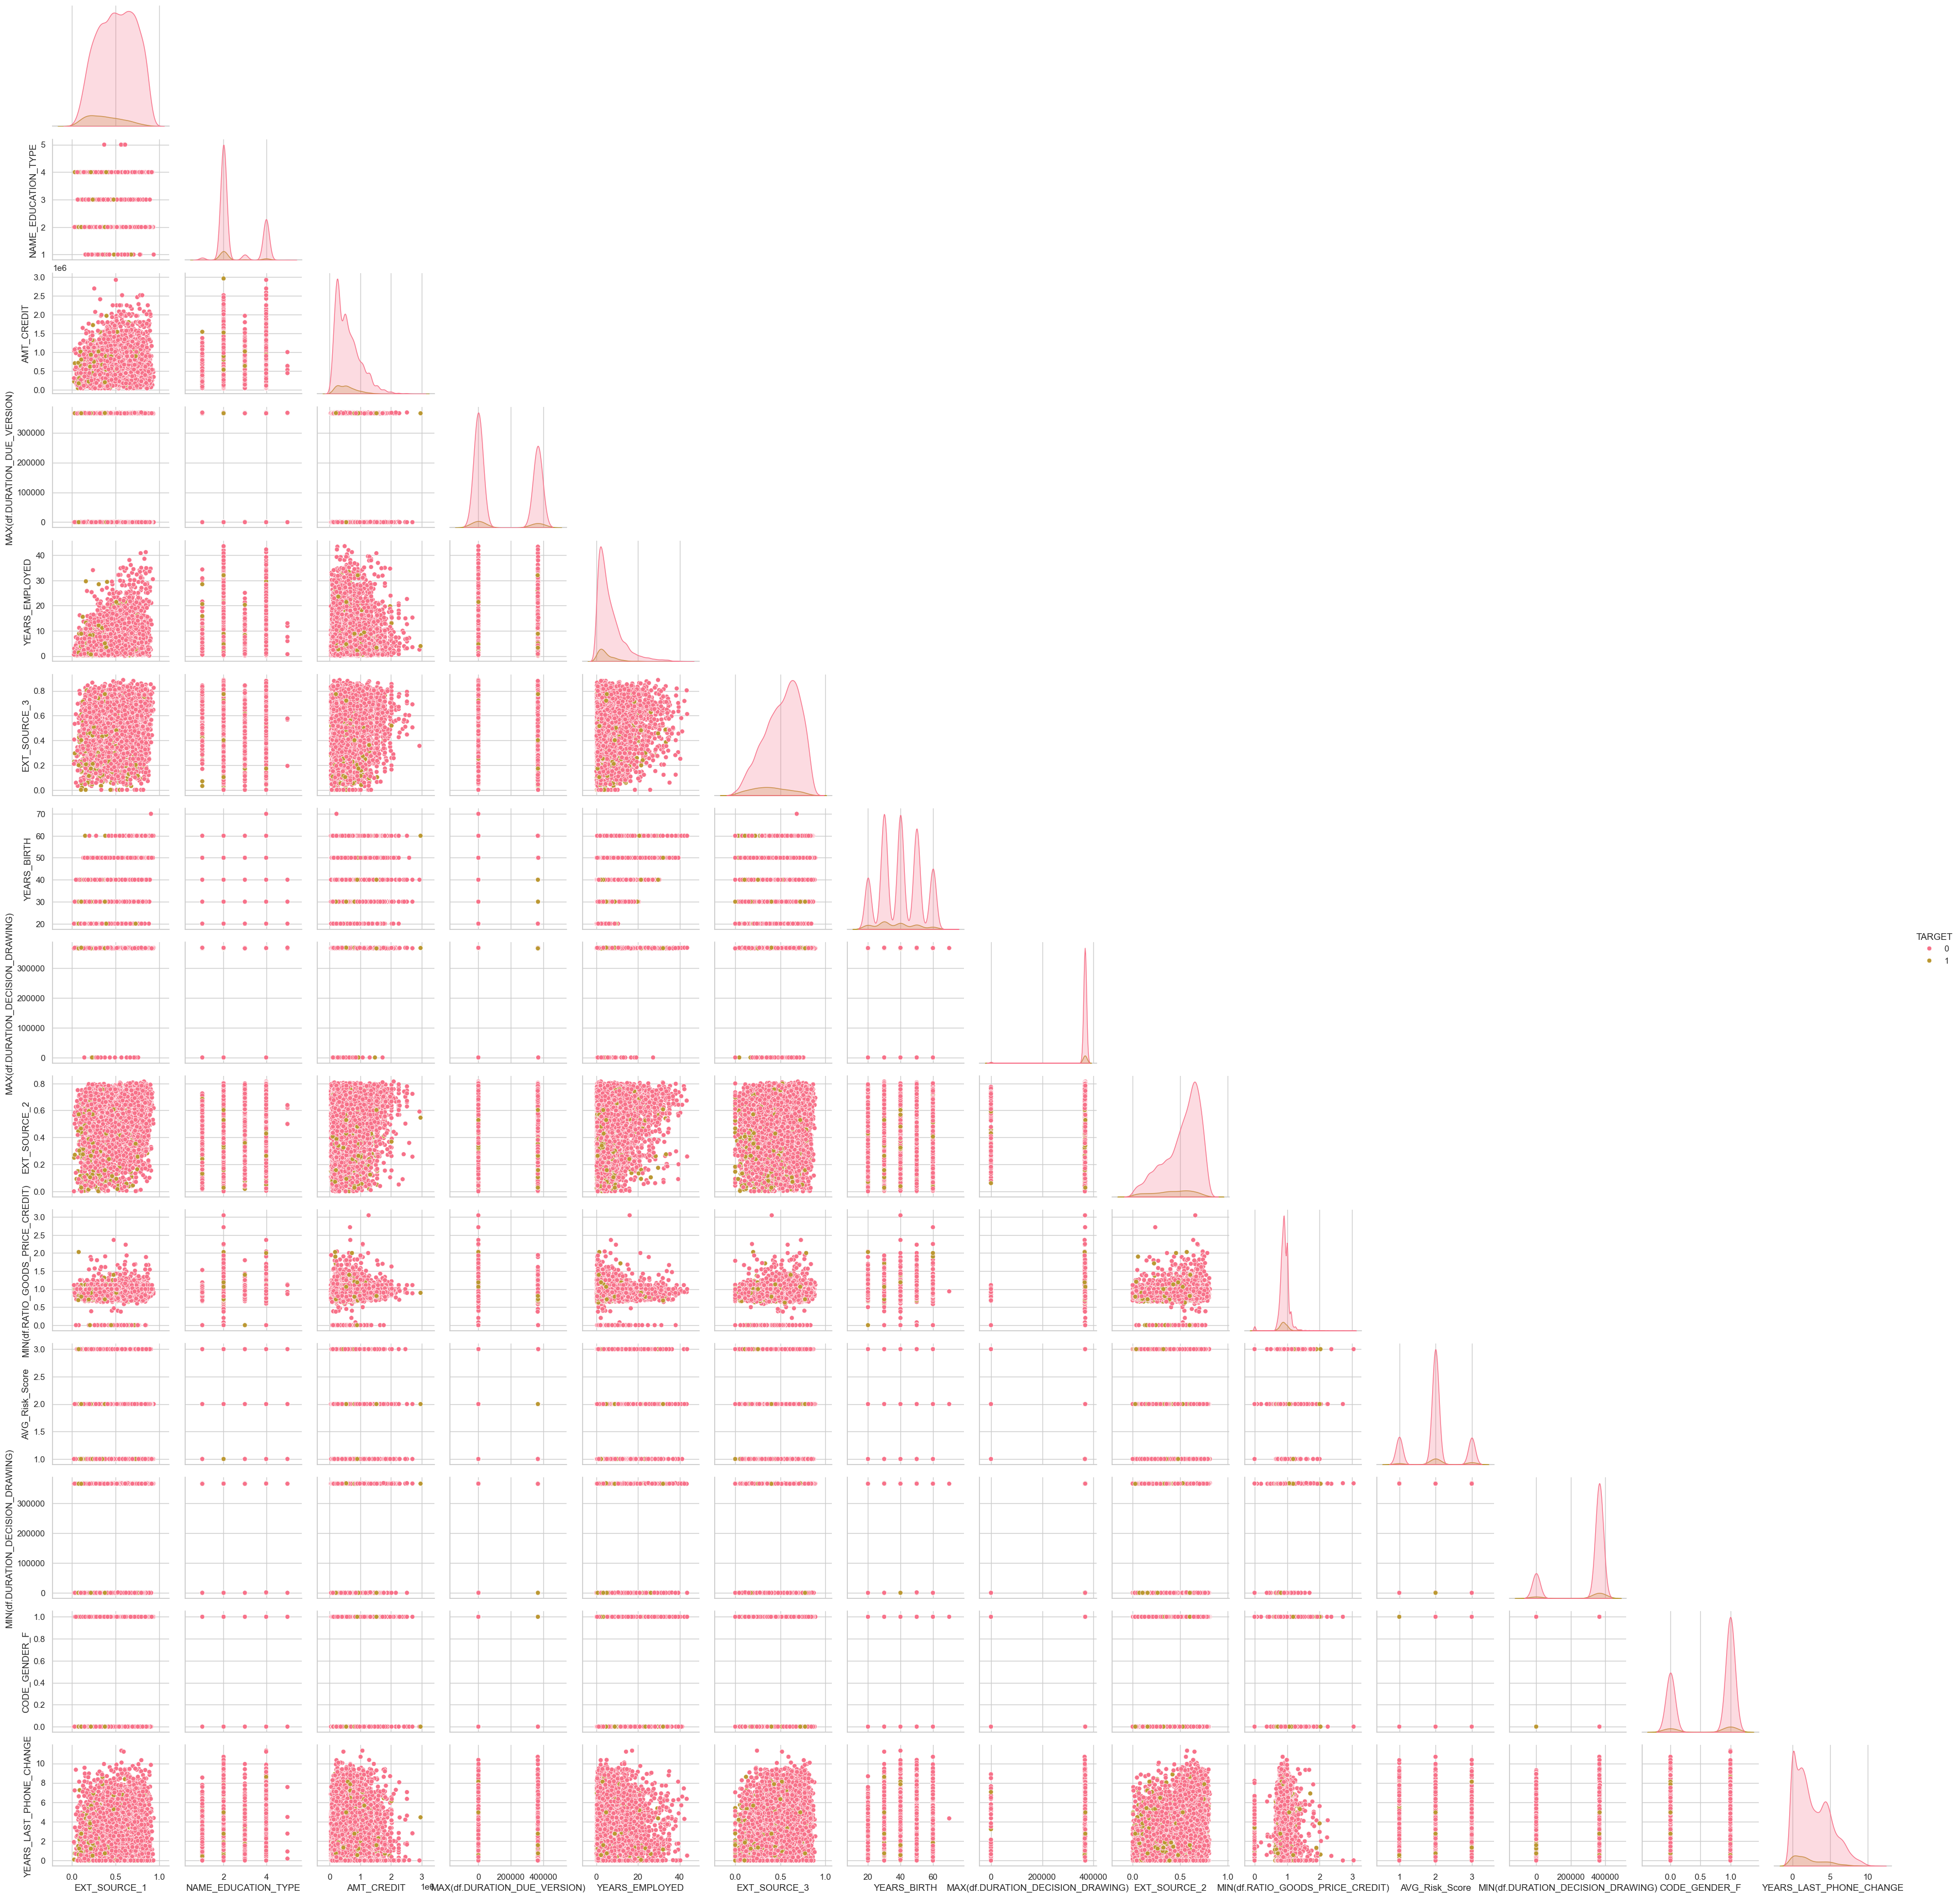

In [69]:
sns.pairplot(selected_data.sample(10000, random_state=42),
             corner=True, hue='TARGET')
plt.show()

PairPlot also doen't show any linear relationship within the selected features.

## Familiarizing with data
In this part, some questions on data dependencies will be answered.

Null Hypothesis (H0): There is no relationship between 'AVG_Risk_Score' and 'CODE_GENDER_F'. <br>
Alternative Hypothesis (H1): There is a relationship between 'AVG_Risk_Score' and 'CODE_GENDER_F'.

In [70]:
help_stats.significance_t_test(selected_data[selected_data['AVG_Risk_Score'].notna(
)], 'AVG_Risk_Score', 'CODE_GENDER_F', 0, 1)

p-value = 0.0000 between AVG_Risk_Score and CODE_GENDER_F. Reject null hypothesis


Both genders have different risk scores, but could this be due to difference in age?

In [71]:
help_stats.confidence_intervals(
    selected_data[selected_data['CODE_GENDER_F'] == 1]['YEARS_BIRTH'], 'Continuous')

Confidence Interval: [41.11, 41.21]


In [72]:
help_stats.confidence_intervals(
    selected_data[selected_data['CODE_GENDER_F'] == 0]['YEARS_BIRTH'], 'Continuous')

Confidence Interval: [37.37, 37.51]


There is a 95% Confidence interval difference between the ages of different genders, but overall it's of 4 years.

In correlation matrix it was seen that YEARS_BIRTH and YEARS_EMPLOYED are not correlated, meaning that people change jobs and are not sticking to the same job for life.

Null Hypothesis (H0): There is no relationship between 'AVG_Risk_Score' and 'YEARS_BIRTH' / 'YEARS_EMPLOYED'. <br>
Alternative Hypothesis (H1): There is a relationship between 'AVG_Risk_Score' and 'YEARS_BIRTH' / 'YEARS_EMPLOYED'.

In [73]:
help_stats.pearson_correlation_test(selected_data.dropna(
    subset='AVG_Risk_Score'), 'AVG_Risk_Score', 'YEARS_BIRTH')

p-value = 0.0000 between AVG_Risk_Score and YEARS_BIRTH. Reject null hypothesis


In [74]:
help_stats.pearson_correlation_test(selected_data.dropna(
    subset=['AVG_Risk_Score', 'YEARS_EMPLOYED']), 'AVG_Risk_Score', 'YEARS_EMPLOYED')

p-value = 0.0000 between AVG_Risk_Score and YEARS_EMPLOYED. Reject null hypothesis


### Conclusion
Age, Years of employment, Gender influence Risk Score, also are related to TARGET itself in a non linear fashion. In correlation matrix it was seen that Age and Years of employment have almost no correlation (0.34) which shows that Risk Profile is made of complicated relationships.

## External Sources
External Sources don't have the same distribution and are probably not related. In the next Notebook (Model), External Sources will be imputed, but since the distribution is not similar, so K-K-Nearest Neighbors (KNN) Imputation won't work. 

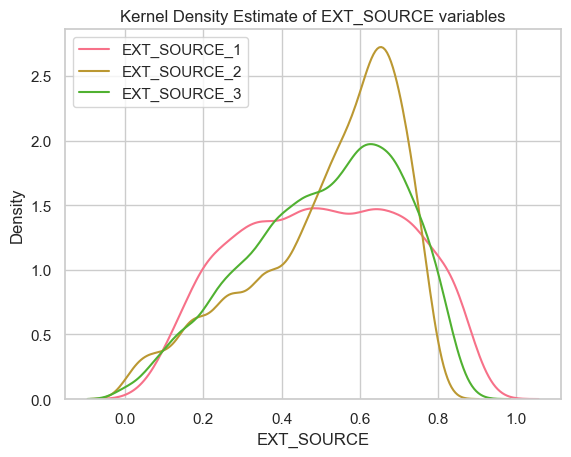

In [75]:
sample_data = selected_data.sample(10000, random_state=42)

for feature in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
    sns.kdeplot(sample_data, x=feature, label=feature)


plt.xlabel('EXT_SOURCE')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of EXT_SOURCE variables')


plt.legend()
plt.show()

Previously it was seen that AVG_Risk_Score has very low scores of R2 when creating a model.

Null Hypothesis (H0): There is no relationship between 'AVG_Risk_Score' and 'TARGET'. <br>
Alternative Hypothesis (H1): There is a relationship between 'AVG_Risk_Score' and 'TARGET'.

In [76]:
help_stats.significance_t_test(selected_data[selected_data['AVG_Risk_Score'].notna(
)], 'AVG_Risk_Score', 'TARGET', 0, 1)

p-value = 0.0000 between AVG_Risk_Score and TARGET. Reject null hypothesis


Despite no prospects of imputing AVG_Risk_Score, it is still related to TARGET.

# Conclusion
Dataset represents:
* Most customers are 'Secondary / secondary special' educated (encoded with 2)
* Have employment of 0-20 years
* Are in their 40s
* Take the exact amount of credit they need for their goods (AMT_GOODS_PRICE / AMT_CREDIT is RATIO_GOODS_PRICE_CREDIT)
* Have medium risk on their previous application (AVG_Risk_Score)
* Are mostly female
* AVG_Risk_Score of previous applications are significantly influenced by Years of employment, Age, Gender. Interestingly, none of the features are correlated.
* External Scores are not correlated to each other, Target or AVG_Risk_Score. This shows they are derived from different datasets.
* Features are not linearly related to each other.